In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torch.nn.functional import interpolate
from torchvision import transforms
from torch.utils.data import DataLoader

from super_resolution.src.sen2venus_dataset import (
    create_train_validation_test_split,
    default_patch_transform,
)
from super_resolution.src.visualization import plot_gallery
from super_resolution.src.srgan import SRResNet, TruncatedVGG19

In [3]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

In [143]:
sites = {
    "SO2",
    # "ES-LTERA",
}
train_patches, val_patches, test_patches = create_train_validation_test_split(
    str(SITES_DIR) + "\\", sites=sites
)
print(
    f"Num train {len(train_patches)}\n"
    f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

Num train 516
Num validation 111
Num test 111


In [144]:
# Compute data mean and std for chennels
train_patches.set_transform(lambda x, y: (x[:3, :, :], y[:3, :, :]))
loader = DataLoader(train_patches, batch_size=256)
channel_means = torch.zeros((3, 1, 1))
channel_std = torch.zeros((3, 1, 1))

for low_res, high_res in loader:
    channel_means += torch.mean(low_res, (0, 2, 3), keepdim=True).squeeze(0)
    channel_std += torch.std(low_res, (0, 2, 3), keepdim=True).squeeze(0)

channel_means /= len(loader)
channel_std /= len(loader)

In [145]:
channel_means

tensor([[[0.0480]],

        [[0.0763]],

        [[0.0792]]])

In [146]:
channel_std

tensor([[[0.0262]],

        [[0.0334]],

        [[0.0517]]])

In [147]:
def image_transform(x, y):
    x = x[:3, :, :]
    y = y[:3, :, :]
    x_channel_max = x.max(dim=1)[0].max(1)[0].unsqueeze(1).unsqueeze(1)
    x_channel_min = x.min(dim=1)[0].min(1)[0].unsqueeze(1).unsqueeze(1)
    y_channel_max = y.max(dim=1)[0].max(1)[0].unsqueeze(1).unsqueeze(1)
    y_channel_min = y.min(dim=1)[0].min(1)[0].unsqueeze(1).unsqueeze(1)

    x = (x - x_channel_min) / (x_channel_max - x_channel_min)
    y = (y - y_channel_min) / (y_channel_max - y_channel_min)

    return x, y


def image_transform(x, y):
    x = x[:3, :, :]
    y = y[:3, :, :]

    x = (x - channel_means) / channel_std

    return x, y

In [148]:
train_patches.set_transform(image_transform)

In [149]:
train_loader = DataLoader(train_patches, batch_size=2)

In [150]:
(low_res, high_res) = next(train_loader.__iter__())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


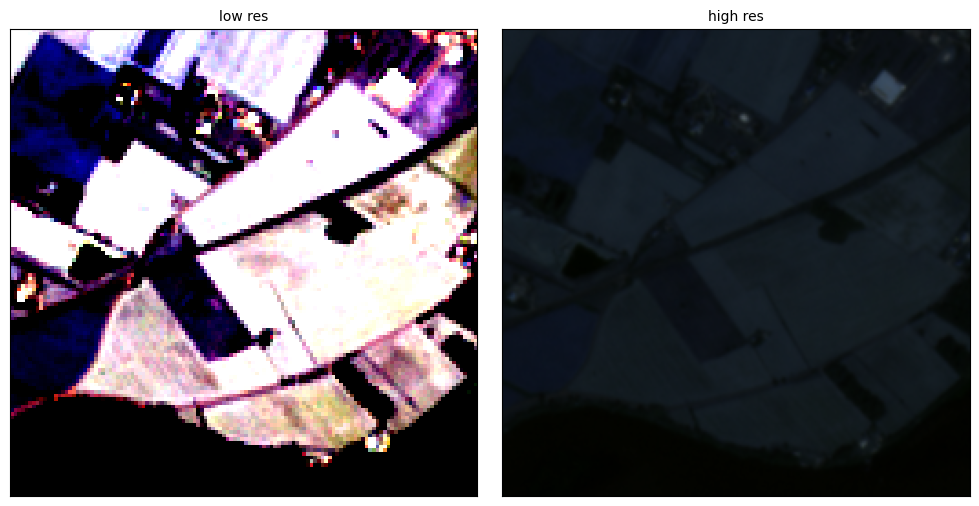

In [151]:
low_res_example = low_res[0]
high_res_example = high_res[0]
plot_gallery(
    [low_res_example.permute(1, 2, 0), high_res_example.permute(1, 2, 0)],
    titles=["low res", "high res"],
    xscale=5,
    yscale=5,
)

In [152]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.cuda.empty_cache()
should_pin_memory = {"cuda": True, "cpu": False}

train_loader = DataLoader(
    train_patches,
    shuffle=True,  # Always set to true for training
    batch_size=16,  # Always try to set as powers of 2
    drop_last=True,  # Ensures batch size is always the one given (Drops last if its is smaller)
    pin_memory=should_pin_memory[device.type],  # Faster push to GPU
    num_workers=0,  # Load data in parallel but costs more memory
)

In [153]:
device

device(type='cuda')

In [154]:
model = SRResNet(scaling_factor=2)

In [155]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.000001)

In [46]:
1 / 0

ZeroDivisionError: division by zero

In [47]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [167]:
model = model.to(device)
model = model.train()

In [157]:
vgg = TruncatedVGG19().to(device)
vgg = vgg.eval()

In [158]:
NUM_EPOCHS = 5

In [159]:
losses = []
epoch_losses = []

In [168]:
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm.tqdm(train_loader, total=len(train_loader), ncols=100)
    epoch_loss = 0.0
    for low_res_batch, high_res_batch in progress_bar:
        # Push to GPU
        low_res_batch = low_res_batch.to(device)
        high_res_batch = high_res_batch.to(device)

        optimizer.zero_grad()

        # Loss and update
        out = model(low_res_batch)
        low_vgg = vgg(out)
        high_vgg = vgg(high_res_batch).detach()
        loss = criterion(low_vgg, high_vgg)
        loss.backward()
        optimizer.step()

        # Collect data
        epoch_loss += loss.item()
        losses.append(loss.item())
        progress_bar.set_postfix(epoch=epoch, batch_loss=loss.item())

    epoch_loss /= len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch: {epoch} / loss: {epoch_loss:.5f}")

100%|███████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.0133, epoch=0]


Epoch: 0 / loss: 0.01430


100%|███████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s, batch_loss=0.0145, epoch=1]


Epoch: 1 / loss: 0.01255


100%|██████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00951, epoch=2]


Epoch: 2 / loss: 0.01076


100%|██████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.00933, epoch=3]


Epoch: 3 / loss: 0.00958


100%|███████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s, batch_loss=0.0079, epoch=4]

Epoch: 4 / loss: 0.00847


In [169]:
len(epoch_losses)

10

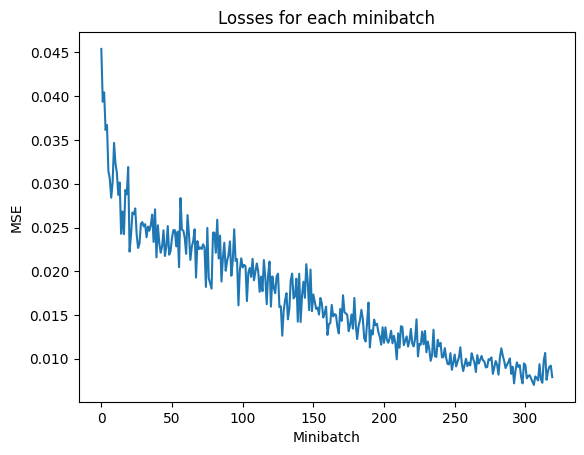

In [170]:
plt.plot(losses)
plt.title("Losses for each minibatch")
plt.xlabel("Minibatch")
plt.ylabel("MSE")
plt.show()

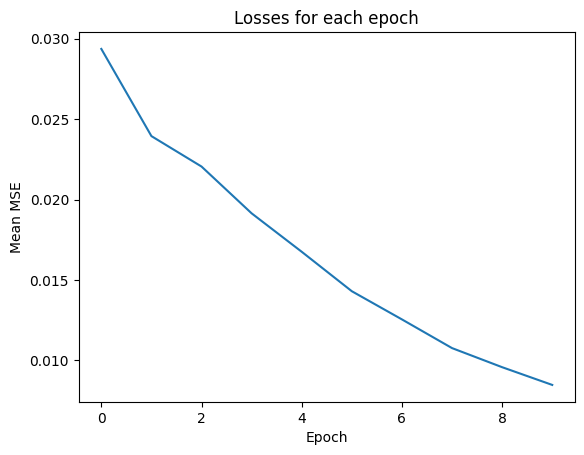

In [171]:
plt.plot(epoch_losses)
plt.title("Losses for each epoch")
plt.xlabel("Epoch")
plt.ylabel("Mean MSE")
plt.show()

In [ ]:
experiment = {
    "epoch_losses": epoch_losses,
    "batch_losses": losses,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
}
save_file = RESULTS_DIR / "basic_sr_results.pkl"

In [172]:
loader = DataLoader(test_patches, batch_size=100)
(low_res, high_res) = next(train_loader.__iter__())

In [173]:
model = model.to("cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


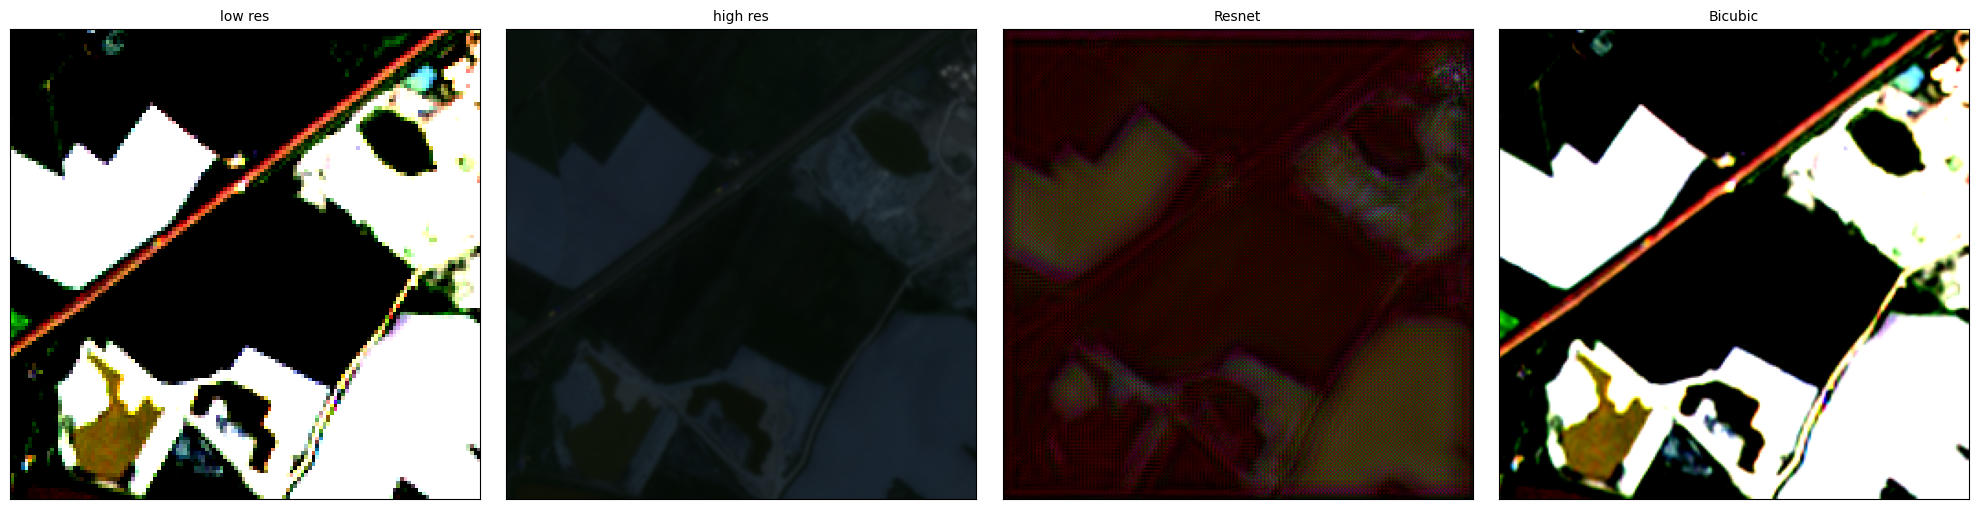

In [174]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = model(low_res_example.unsqueeze(0)).detach()
bicubic_out = interpolate(
    low_res_example.unsqueeze(0), size=(256, 256), mode="bicubic"
).float()
plot_gallery(
    [
        low_res_example.permute(1, 2, 0),
        high_res_example.permute(1, 2, 0),
        out[0].permute(1, 2, 0),
        bicubic_out[0].permute(1, 2, 0),
    ],
    titles=["low res", "high res", "Resnet", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [129]:
loader = DataLoader(train_patches, batch_size=100)
(low_res, high_res) = next(train_loader.__iter__())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


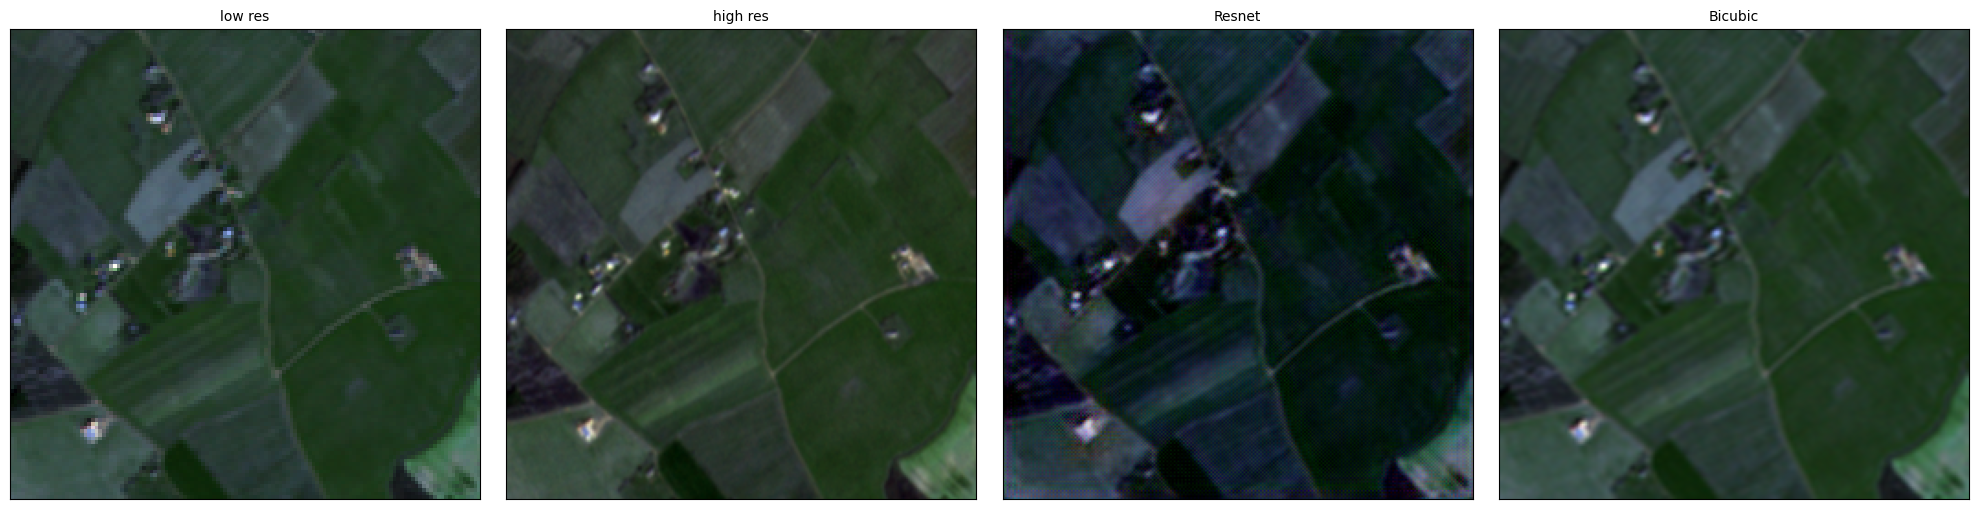

In [130]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = model(low_res_example.unsqueeze(0)).detach()
bicubic_out = interpolate(
    low_res_example.unsqueeze(0), size=(256, 256), mode="bicubic"
).float()
plot_gallery(
    [
        low_res_example.permute(1, 2, 0),
        high_res_example.permute(1, 2, 0),
        out[0].permute(1, 2, 0),
        bicubic_out[0].permute(1, 2, 0),
    ],
    titles=["low res", "high res", "Resnet", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [1]:
print("hello world")

hello world
